In [1]:
!wget https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v2_images.zip
!wget https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_foreground.zip

--2023-03-05 05:14:13--  https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v2_images.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68389595 (65M) [application/zip]
Saving to: ‘BBBC010_v2_images.zip’

BBBC010_v2_images.z 100%[===================>]  65.22M  7.98MB/s    in 8.8s    

2023-03-05 05:14:22 (7.40 MB/s) - ‘BBBC010_v2_images.zip’ saved [68389595/68389595]

--2023-03-05 05:14:22--  https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_foreground.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1097766 (1.0M) [application/zip]
Saving to: ‘BBBC010_v1_foreground.zip’

BBBC010_v1_foregrou 100%[===================>]   1

In [2]:
!mkdir -p Data/Images
!mkdir -p Data/Masks

In [3]:
!unzip "/content/BBBC010_v2_images.zip" -d "/content/Data/Images"
!unzip "/content/BBBC010_v1_foreground.zip" -d "/content/Data/Masks"

Archive:  /content/BBBC010_v2_images.zip
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_A22_w2_272E362F-7461-473A-83C0-13DBD2E25D7E.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_D15_w1_85DF50DF-61A8-4A13-9209-232979A3D80E.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_C14_w1_B15ED9AD-6E61-4D35-8BBA-0076E6315996.tif  
   creating: /content/Data/Images/__MACOSX/
  inflating: /content/Data/Images/__MACOSX/._1649_1109_0003_Amp5-1_B_20070424_C14_w1_B15ED9AD-6E61-4D35-8BBA-0076E6315996.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_C05_w1_F5EEE7FF-DA3E-4BE0-B028-D8CF92A3F35E.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_B08_w2_E09DF96B-5EC9-4476-BFBB-9057C6D6C81C.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_A14_w2_B81874A1-E193-4A3A-BEBD-77D84E975901.tif  
  inflating: /content/Data/Images/1649_1109_0003_Amp5-1_B_20070424_C18_w1_A32EC918-BB

In [4]:
!rm -r "/content/Data/Images/__MACOSX"

## **Importing libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image# for RGB images
import os
from sklearn.model_selection import train_test_split
import cv2# cv2.imread() for grayscale images
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

### **Loading the data**

In [6]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """
    Add a vertical color bar to an image plot.
    
    """
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [7]:
img_folder = '/content/Data/Images'
mask_folder = '/content/Data/Masks/BBBC010_v1_foreground'

In [8]:
target_height = 400
target_width = target_height

In [9]:
N_imgs = 100
# 100 images with 2 channels for each image

img_filenames = np.array(sorted(os.listdir(img_folder)))  # Sort to alphabetical order
assert len(img_filenames) == N_imgs*2

In [10]:
# Listing the images' 'categories'. For ex, A0, A1, etc.
wells = [f.split('_')[6] for f in img_filenames]
wells = np.sort(np.unique(wells))
channels = [1,2]

wells[:3]

array(['A01', 'A02', 'A03'], dtype='<U3')

In [11]:
#%%load the images
#images, 2 channels
X = np.zeros(shape=(N_imgs,target_height,target_width,2),dtype='float32')
Y = np.zeros(shape=(N_imgs,target_height,target_width,1),dtype='float32')

In [12]:
i = 0
for w in  wells:
    print('loading image ',i+1)
    for c in channels:
        key = w+'_w'+str(c)
        img_file = None
        for f in img_filenames:
            if key in f:
                img_file=f
                break;
        print(img_file)
        #cv2 is better for grayscale images, use 
        #load the image
        img = cv2.imread(img_folder+'/'+img_file,-1)
        #resize
        img=cv2.resize(img,(target_width,target_height))
        #normalize to 0-1
        img=img/img.max()
        X[i,:,:,c-1]=img
    print('loading mask')
    img = cv2.imread(mask_folder+'/'+w+'_binary.png',cv2.IMREAD_GRAYSCALE)
    #resize
    img=cv2.resize(img,(target_width,target_height))
    #normalize to 0-1
    img=img/img.max()
    #create binary image from [0,1] to {0,1}, using 0.5 as threshold
    img[img<0.5]=0
    img[img>=0.5]=1
    Y[i,:,:,0]=img
    i=i+1
    print()#add a blank line for readability

loading image  1
1649_1109_0003_Amp5-1_B_20070424_A01_w1_9E84F49F-1B25-4E7E-8040-D1BB2D7E73EA.tif
1649_1109_0003_Amp5-1_B_20070424_A01_w2_15ADF48D-C09E-47DE-B763-5BC479534681.tif
loading mask

loading image  2
1649_1109_0003_Amp5-1_B_20070424_A02_w1_773004B9-5D0A-4322-AFC2-CF6D9D5068A9.tif
1649_1109_0003_Amp5-1_B_20070424_A02_w2_B4155909-4B0A-4A31-8954-4B3745953415.tif
loading mask

loading image  3
1649_1109_0003_Amp5-1_B_20070424_A03_w1_B8A27DE7-1DC3-492C-B77A-CAFED6A897A6.tif
1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.tif
loading mask

loading image  4
1649_1109_0003_Amp5-1_B_20070424_A04_w1_627EA5BE-2ED8-436F-A347-1BE04E460894.tif
1649_1109_0003_Amp5-1_B_20070424_A04_w2_0A271281-741F-478E-93B0-9A625F2747E1.tif
loading mask

loading image  5
1649_1109_0003_Amp5-1_B_20070424_A05_w1_737744FB-FCE1-46A9-9F41-F95EF94715DF.tif
1649_1109_0003_Amp5-1_B_20070424_A05_w2_9F329A58-2D6D-42E2-9E6D-E23ACBACE9E0.tif
loading mask

loading image  6
1649_1109_0003_Amp

In [13]:
#double-check that the masks are binary
assert np.array_equal(np.unique(Y), [0,1])

Text(0.5, 1.0, 'A05 mask')

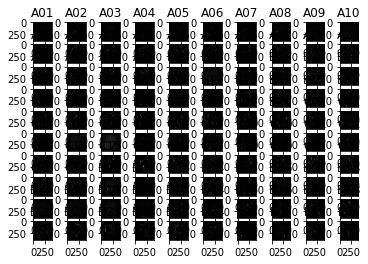

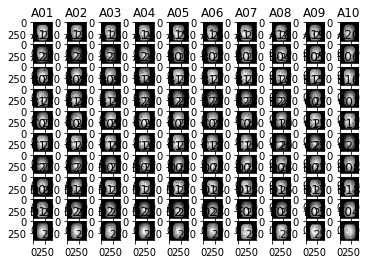

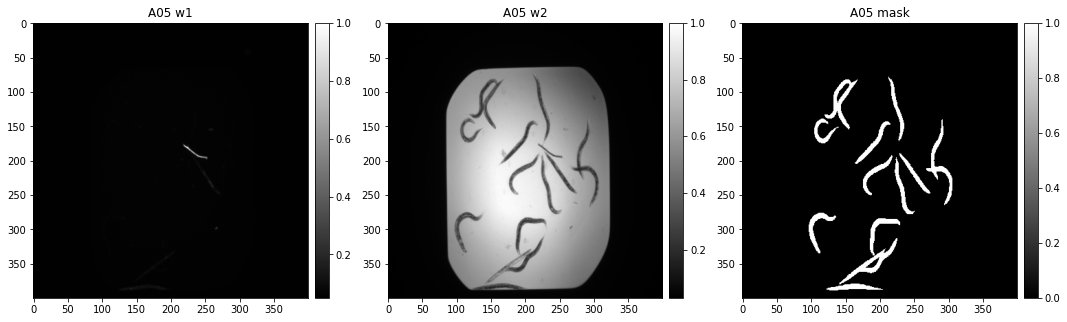

In [14]:
#%% plot as a sanity check

#plot channel 0
img=0    
fig, axes = plt.subplots(10,10)
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(X[img,:,:,0],cmap='gray')
        axes[i,j].set_title(wells[img])
        img=img+1

#plot channel 1
img=0    
fig, axes = plt.subplots(10,10)
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(X[img,:,:,1],cmap='gray')
        axes[i,j].set_title(wells[img])
        img=img+1   

#%%
i=4
plt.figure(figsize=(3*6,6))
plt.subplot(1,3,1)
im=plt.imshow(X[i,:,:,0],cmap='gray')
add_colorbar(im)
plt.title(wells[i]+' w1')

plt.subplot(1,3,2)
im=plt.imshow(X[i,:,:,1],cmap='gray')
add_colorbar(im)
plt.title(wells[i]+' w2')

plt.subplot(1,3,3)
im=plt.imshow(Y[i,:,:,0],cmap='gray')
add_colorbar(im)
plt.title(wells[i]+' mask')

In [15]:
#%% split into train, validation and test sets

ix = np.arange(len(wells))

ix_tr, ix_val_ts = train_test_split(ix,train_size=60, random_state=0)
ix_val, ix_ts = train_test_split(ix_val_ts,train_size=20, random_state=0)

#sanity check, no overlap between train, validation and test sets
assert len(np.intersect1d(ix_tr,ix_val))==0
assert len(np.intersect1d(ix_tr,ix_ts))==0
assert len(np.intersect1d(ix_val,ix_ts))==0

X_tr = X[ix_tr,:]
Y_tr = Y[ix_tr,:]

X_val = X[ix_val,:]
Y_val = Y[ix_val,:]

X_ts = X[ix_ts,:]
Y_ts = Y[ix_ts,:]

fnames_tr = wells[ix_tr].tolist()
fnames_val = wells[ix_val].tolist()
fnames_ts = wells[ix_ts].tolist()

fname_split = ['train']*len(fnames_tr)+['validation']*len(fnames_val)+['test']*len(fnames_ts)
df=pd.DataFrame({'well':fnames_tr+fnames_val+fnames_ts,
              'split':fname_split})

#save to disk
df.to_csv('./Data/training_validation_test_splits.csv',index=False)

np.save('./Data/X_tr.npy',X_tr)
np.save('./Data/X_val.npy',X_val)
np.save('./Data/X_ts.npy',X_ts)

np.save('./Data/Y_tr.npy',Y_tr)
np.save('./Data/Y_val.npy',Y_val)
np.save('./Data/Y_ts.npy',Y_ts)

## **UNet-Training**

In [16]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.layers import concatenate #Concatenate (capital C) not working 
#from keras.utils.vis_utils import plot_model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import time
import skimage.transform

In [ ]:
#load the data from already split files
X_tr = np.load('./Data/X_tr.npy')
Y_tr = np.load('./Data/Y_tr.npy')

X_val = np.load('./Data/X_val.npy')
Y_val = np.load('./Data/Y_val.npy')

In [ ]:
#model parameters
bnorm_axis = -1
#filter sizes of the original model
nfilters = np.array([64, 128, 256, 512, 1024])

#downsize the UNET for this example.
#the smaller network is faster to train
#and produces excellent results on the dataset at hand
nfilters = (nfilters/8).astype('int')

#input
input_tensor = Input(shape=X_tr.shape[1:], name='input_tensor')

In [ ]:
####################################
# encoder (contracting path)
####################################
#encoder block 0
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)

#encoder block 1
e1 = MaxPooling2D((2, 2))(e0)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)

#encoder block 2
e2 = MaxPooling2D((2, 2))(e1)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)

#encoder block 3
e3 = MaxPooling2D((2, 2))(e2)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)

#encoder block 4
e4 = MaxPooling2D((2, 2))(e3)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
#e4 = MaxPooling2D((2, 2))(e4)

####################################
# decoder (expansive path)
####################################

#decoder block 3
d3=UpSampling2D((2, 2),)(e4)
d3=concatenate([e3,d3], axis=-1)#skip connection
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)

#decoder block 2
d2=UpSampling2D((2, 2),)(d3)
d2=concatenate([e2,d2], axis=-1)#skip connection
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)

#decoder block 1
d1=UpSampling2D((2, 2),)(d2)
d1=concatenate([e1,d1], axis=-1)#skip connection
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)

#decoder block 0
d0=UpSampling2D((2, 2),)(d1)
d0=concatenate([e0,d0], axis=-1)#skip connection
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)

In [ ]:
#output
#out_class = Dense(1)(d0)
out_class = Conv2D(1, (1, 1), padding='same')(d0)
out_class = Activation('sigmoid',name='output')(out_class)

#create and compile the model
model=Model(inputs=input_tensor,outputs=out_class)
model.compile(loss={'output':'binary_crossentropy'},
              metrics={'output':'accuracy'},
              optimizer='adam')

#%%
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tensor (InputLayer)      [(None, 400, 400, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 8)  152         ['input_tensor[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
#%% train the model
filepath = 'unet_div8_495K'

#save the model when val_loss improves during training
checkpoint = ModelCheckpoint('./trained_models/'+filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#save training progress in a .csv
csvlog = CSVLogger('./trained_models/'+filepath+'_train_log.csv',append=True)
#stop training if no improvement has been seen on val_loss for a while
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
batch_size=4

In [ ]:
#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))

### **Data Augmentation**

In [17]:
def rotateT(X,angle):
    #rotate image tensor, TF order, single channel
    X_rot = np.zeros_like(X)
    #repeat for every channel
    for ch in np.arange(X.shape[-1]):
        #print('channel',ch)
        #repeat for every image
        for i in np.arange(X.shape[0]):
            #print('image',i)
            X_rot[i,:,:,ch] = skimage.transform.rotate(X[i,:,:,ch],angle=angle,resize=False,preserve_range=True,mode='edge')
    return(X_rot)

def shiftT(X,dx,dy):
    #rotate image tensor, TF order, single channel
    X_shift = np.zeros_like(X)
    #repeat for every image
    tform = skimage.transform.SimilarityTransform(translation=(dx, dy))
    for i in np.arange(X.shape[0]):
        #print('image',i)
        X_shift[i,:,:,:] = skimage.transform.warp(X[i,:,:,:],tform,mode='edge')
    return(X_shift)

#%%
def aug_generator(X_raw=None,Y_raw=None,
                  batch_size=4,
                  flip_axes=['x','y'],
                  rotation_angles=[5,15]):
                  #noise_gaussian_mean=0,
                  #noise_gaussian_var=1e-2):
                  #noise_snp_amount=0.05):
    
    batch_size=batch_size#recommended batch size    
    Ndatapoints = len(X_raw)
    #Naugmentations=4 #original + flip, rotation, noise_gaussian, noise_snp
    
    while(True):
        #print('start!')
        ix_randomized = np.random.choice(Ndatapoints,size=Ndatapoints,replace=False)
        ix_batches = np.array_split(ix_randomized,int(Ndatapoints/batch_size))
        for b in range(len(ix_batches)):
            #print('step',b,'of',len(ix_batches))
            ix_batch = ix_batches[b]
            current_batch_size=len(ix_batch)
            #print('size of current batch',current_batch_size)
            #print(ix_batch)
            X_batch = X_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            Y_batch = Y_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            
            #now do augmentation on images and masks
            #iterate over each image in the batch
            for img in range(current_batch_size):
                #print('current_image',img,': ',ix_batch[img])
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('flipping',img)
                    flip_axis_selected = np.random.choice(flip_axes,1,replace=False)[0]
                    if flip_axis_selected == 'x':
                        flip_axis_selected = 1
                    else: # 'y'
                        flip_axis_selected = 0
                    #flip an axis
                    X_batch[img,:,:,:] = np.flip(X_batch[img,:,:,:],axis=flip_axis_selected)
                    Y_batch[img,:,:,:] = np.flip(Y_batch[img,:,:,:],axis=flip_axis_selected)
                    #print('Flip on axis',flip_axis_selected)
                
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('rotating',img)
                    rotation_angle_selected = np.random.uniform(low=rotation_angles[0],high=rotation_angles[1],size=1)[0]
                    #rotate the image
                    X_batch[img,:,:,:] = rotateT(np.expand_dims(X_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    Y_batch[img,:,:,:] = rotateT(np.expand_dims(Y_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    #print('Rotate angle',rotation_angle_selected)
            yield(X_batch,Y_batch)
            #print('step end after',b,'of',len(ix_batches))

In [ ]:
#initialize the generator
gen_train = aug_generator(X_tr,Y_tr,batch_size=batch_size,flip_axes=[1,2])
#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))

#actually do the training
model.fit_generator(generator=gen_train,
                    steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                    validation_data=(X_val,Y_val),
                    epochs=200,
                    verbose=2,
                    initial_epoch=0,
                    callbacks=[checkpoint, csvlog, early_stopping])

<ipython-input-24-9f47af69a2d0>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=gen_train,


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.61966, saving model to ./trained_models/unet_div8_495K.hdf5
15/15 - 85s - loss: 0.3640 - accuracy: 0.9442 - val_loss: 0.6197 - val_accuracy: 0.9618 - 85s/epoch - 6s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.61966 to 0.54238, saving model to ./trained_models/unet_div8_495K.hdf5
15/15 - 72s - loss: 0.2690 - accuracy: 0.9768 - val_loss: 0.5424 - val_accuracy: 0.9618 - 72s/epoch - 5s/step
Epoch 3/200

Epoch 3: val_loss improved from 0.54238 to 0.42379, saving model to ./trained_models/unet_div8_495K.hdf5
15/15 - 67s - loss: 0.2183 - accuracy: 0.9791 - val_loss: 0.4238 - val_accuracy: 0.9618 - 67s/epoch - 4s/step
Epoch 4/200

Epoch 4: val_loss improved from 0.42379 to 0.38464, saving model to ./trained_models/unet_div8_495K.hdf5
15/15 - 65s - loss: 0.1920 - accuracy: 0.9816 - val_loss: 0.3846 - val_accuracy: 0.9618 - 65s/epoch - 4s/step
Epoch 5/200

Epoch 5: val_loss improved from 0.38464 to 0.36855, saving model to ./trained_m

## **Evaluation of the model**

In [ ]:
#%% get predicted masks for test set
#model = load_model('./trained_models/'+filepath+'.hdf5')

model.load_weights('./trained_models/'+filepath+'.hdf5')
Y_ts_hat = model.predict(X_ts,batch_size=1)

20/20 [==============================] - 7s 310ms/step


In [ ]:
def dice2D(a,b):
    #https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i
    #https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    intersection = np.sum(a[b==1])
    dice = (2*intersection)/(np.sum(a)+np.sum(b))
    if (np.sum(a)+np.sum(b))==0: #black/empty masks
        dice=1.0
    return(dice)

In [ ]:
X_ts = np.load('/content/Data/X_ts.npy').astype('float32')
Y_ts = np.load('/content/Data/Y_ts.npy').astype('float32')

In [ ]:
NTest = len(X_ts)

In [ ]:
#%% convert predicted mask to binary
threshold=0.5
Y_ts_hat[Y_ts_hat<threshold]=0
Y_ts_hat[Y_ts_hat>=threshold]=1

#%% calculate dice
dice = []
for i in range(NTest):
    print(i)
    dice.append(dice2D(Y_ts[i,:,:,0],Y_ts_hat[i,:,:,0]))
dice = np.array(dice)

In [ ]:
well_ts = df[df['split']=='test']['well'].tolist()

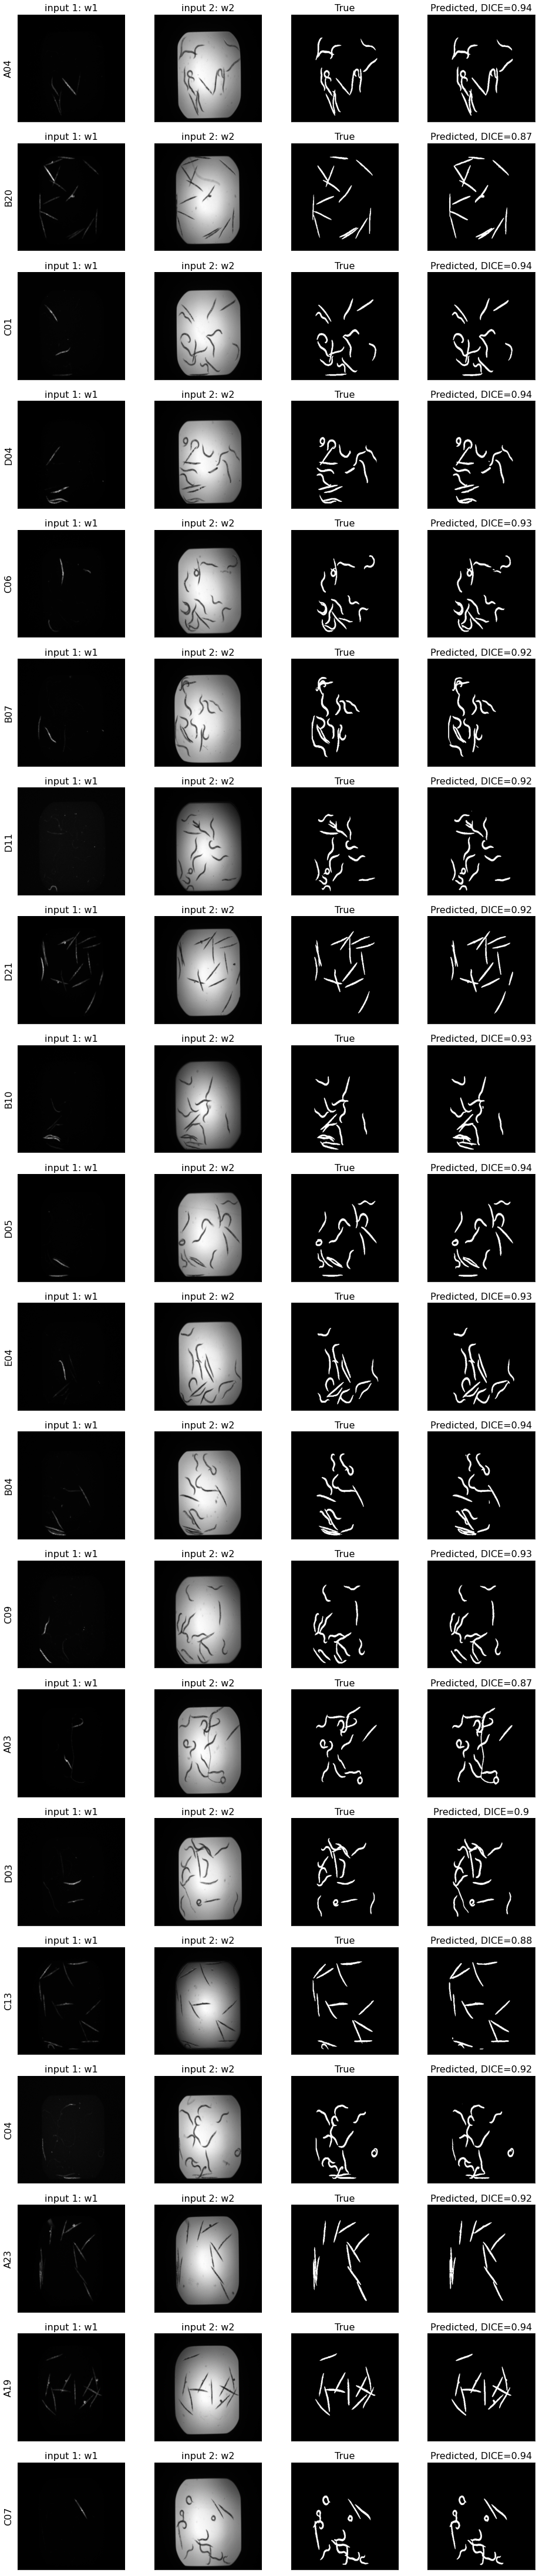

In [ ]:
#%%
fig, axes = plt.subplots(NTest,4,figsize=(4*4,NTest*4))
for i in range(NTest):
    axes[i,0].imshow(X_ts[i,:,:,0], cmap='gray')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('input 1: w1',{'fontsize':16})
    axes[i,0].set_ylabel(well_ts[i],{'fontsize':16})
    
    axes[i,1].imshow(X_ts[i,:,:,1], cmap='gray')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('input 2: w2',{'fontsize':16})
    
    axes[i,2].imshow(Y_ts[i,:,:,0], cmap='gray')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('True',{'fontsize':16})
    
    axes[i,3].imshow(Y_ts_hat[i,:,:,0], cmap='gray')
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_title('Predicted, DICE='+str(np.round(dice[i],2)),{'fontsize':16})

In [ ]:
print('mean dice:', dice.mean())
#mean dice: 0.916088477076695
print('median dice:', np.median(dice))

mean dice: 0.9202782922136429
median dice: 0.9260598413277428


## **UNet with Monte-Carlo Dropout**

In [18]:
from keras.layers import Dropout

In [19]:
#model parameters
bnorm_axis = -1
#filter sizes of the original model
nfilters = np.array([64, 128, 256, 512, 1024])
drop_rate=0.5
#drop_train=True
drop_train=False
#downsize the UNET for this example.
#the smaller network is faster to train
#and produces excellent results on the dataset at hand
nfilters = (nfilters/8).astype('int')

In [20]:
#input
input_tensor = Input(shape=X_tr.shape[1:], name='input_tensor')

####################################
# encoder (contracting path)
####################################
#encoder block 0
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)

#encoder block 1
e1 = MaxPooling2D((2, 2))(e0)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)

#encoder block 2
e2 = Dropout(drop_rate)(e1, training = drop_train)
e2 = MaxPooling2D((2, 2))(e2)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)

#encoder block 3
e3 = Dropout(drop_rate)(e2, training = drop_train)
e3 = MaxPooling2D((2, 2))(e3)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)

#encoder block 4
e4 = Dropout(drop_rate)(e3, training = drop_train)
e4 = MaxPooling2D((2, 2))(e4)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
#e4 = MaxPooling2D((2, 2))(e4)

####################################
# decoder (expansive path)
####################################

#decoder block 3
d3 = Dropout(drop_rate)(e4, training = drop_train)
d3=UpSampling2D((2, 2),)(d3)
d3=concatenate([e3,d3], axis=-1)#skip connection
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)

#decoder block 2
d2 = Dropout(drop_rate)(d3, training = drop_train)
d2=UpSampling2D((2, 2),)(d2)
d2=concatenate([e2,d2], axis=-1)#skip connection
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)

#decoder block 1
d1=UpSampling2D((2, 2),)(d2)
d1=concatenate([e1,d1], axis=-1)#skip connection
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)

#decoder block 0
d0=UpSampling2D((2, 2),)(d1)
d0=concatenate([e0,d0], axis=-1)#skip connection
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)

#output
#out_class = Dense(1)(d0)
out_class = Conv2D(1, (1, 1), padding='same')(d0)
out_class = Activation('sigmoid',name='output')(out_class)

#create and compile the model
model=Model(inputs=input_tensor,outputs=out_class)
model.compile(loss={'output':'binary_crossentropy'},
              metrics={'output':'accuracy'},
              optimizer='adam')

#%%
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tensor (InputLayer)      [(None, 400, 400, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 8)  152         ['input_tensor[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [22]:
#%% train the model
filepath = 'mcd_unet_div8_495K'

#save the model when val_loss improves during training
checkpoint = ModelCheckpoint('./trained_models/'+filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#save training progress in a .csv
csvlog = CSVLogger('./trained_models/'+filepath+'_train_log.csv',append=True)
#stop training if no improvement has been seen on val_loss for a while
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
batch_size=4

#initialize the generator
gen_train = aug_generator(X_tr,Y_tr,batch_size=batch_size,flip_axes=[1,2])
#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))

#actually do the training
model.fit_generator(generator=gen_train,
                    steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                    validation_data=(X_val,Y_val),
                    epochs=200,
                    verbose=2,
                    initial_epoch=0,
                    callbacks=[checkpoint, csvlog, early_stopping])


Epoch 1/200


<ipython-input-22-52bcce12831e>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=gen_train,



Epoch 1: val_loss improved from inf to 0.06843, saving model to ./trained_models/mcd_unet_div8_495K.hdf5
15/15 - 82s - loss: 0.0724 - accuracy: 0.9880 - val_loss: 0.0684 - val_accuracy: 0.9922 - 82s/epoch - 5s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.06843 to 0.06785, saving model to ./trained_models/mcd_unet_div8_495K.hdf5
15/15 - 59s - loss: 0.0712 - accuracy: 0.9847 - val_loss: 0.0678 - val_accuracy: 0.9926 - 59s/epoch - 4s/step
Epoch 3/200
15/15 - 63s - loss: 0.0691 - accuracy: 0.9868 - val_loss: 0.0750 - val_accuracy: 0.9930 - 63s/epoch - 4s/step
Epoch 4/200

Epoch 4: val_loss improved from 0.06785 to 0.06666, saving model to ./trained_models/mcd_unet_div8_495K.hdf5
15/15 - 57s - loss: 0.0680 - accuracy: 0.9855 - val_loss: 0.0667 - val_accuracy: 0.9917 - 57s/epoch - 4s/step
Epoch 5/200

Epoch 5: val_loss improved from 0.06666 to 0.06421, saving model to ./trained_models/mcd_unet_div8_495K.hdf5
15/15 - 56s - loss: 0.0666 - accuracy: 0.9855 - val_loss: 0.0642 - val_accur

### **Evaluating the model**

In [25]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """
    Add a vertical color bar to an image plot.
    https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    """
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def dice2D(a,b):
    #https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i
    #https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    intersection = np.sum(a[b==1])
    dice = (2*intersection)/(np.sum(a)+np.sum(b))
    if (np.sum(a)+np.sum(b))==0: #black/empty masks
        dice=1.0
    return(dice)

X_ts = np.load('./Data/X_ts.npy')
Y_ts = np.load('./Data/Y_ts.npy')#.astype('float32')#to match keras predicted mask

Ntest=len(X_ts)

df = pd.read_csv('./Data/training_validation_test_splits.csv')
well_ts = df[df['split']=='test']['well'].tolist()
#Y_ts is a binary mask
#np.unique(Y_ts)
#array([ 0.,  1.], dtype=float32)

filepath = 'mcd_unet_div8_495K'


In [30]:
#%% get predicted masks for test set
#model = load_model('./trained_models/'+filepath+'.hdf5')

model.load_weights('./trained_models/'+filepath+'.hdf5')
Y_ts_hat = model.predict(X_ts,batch_size=1)

#%% iterate over a large number of T models
T = 20 #as in DeVries et al 2018
for t in range(T-1):#already did one above
    print('model',t+1,'of',T-1)
    Y_ts_hat=Y_ts_hat+model.predict(X_ts,batch_size=1)
Y_ts_hat=Y_ts_hat/T
np.save('./Data/Y_ts_hat_'+filepath+'.npy',Y_ts_hat)

20/20 [==============================] - 5s 262ms/step
model 1 of 19
20/20 [==============================] - 5s 273ms/step
model 2 of 19
20/20 [==============================] - 5s 269ms/step
model 3 of 19
20/20 [==============================] - 5s 226ms/step
model 4 of 19
20/20 [==============================] - 5s 265ms/step
model 5 of 19
20/20 [==============================] - 5s 270ms/step
model 6 of 19
20/20 [==============================] - 5s 263ms/step
model 7 of 19
20/20 [==============================] - 5s 226ms/step
model 8 of 19
20/20 [==============================] - 5s 261ms/step
model 9 of 19
20/20 [==============================] - 5s 273ms/step
model 10 of 19
20/20 [==============================] - 5s 225ms/step
model 11 of 19
20/20 [==============================] - 6s 283ms/step
model 12 of 19
20/20 [==============================] - 5s 243ms/step
model 13 of 19
20/20 [==============================] - 4s 223ms/step
model 14 of 19
20/20 [======================

In [31]:
#%%calculate uncertainty
Y_ts_hat=np.load('./Data/Y_ts_hat_'+filepath+'.npy')
P_foreground = Y_ts_hat
P_background = 1-P_foreground

U_ts = -(P_foreground*np.log(P_foreground)+P_background*np.log(P_background))
#np.save('./data/U_ts_'+filepath+'.npy',U_ts)

U_ts_foreground=-(P_foreground*np.log(P_foreground))
U_ts_background=-(P_background*np.log(P_background))

<ipython-input-31-78ce9da89daa>:6: RuntimeWarning: divide by zero encountered in log
  U_ts = -(P_foreground*np.log(P_foreground)+P_background*np.log(P_background))
<ipython-input-31-78ce9da89daa>:6: RuntimeWarning: invalid value encountered in multiply
  U_ts = -(P_foreground*np.log(P_foreground)+P_background*np.log(P_background))
<ipython-input-31-78ce9da89daa>:10: RuntimeWarning: divide by zero encountered in log
  U_ts_background=-(P_background*np.log(P_background))
<ipython-input-31-78ce9da89daa>:10: RuntimeWarning: invalid value encountered in multiply
  U_ts_background=-(P_background*np.log(P_background))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


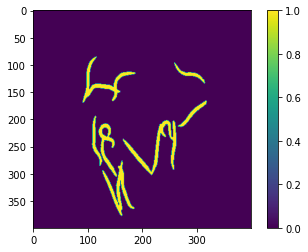

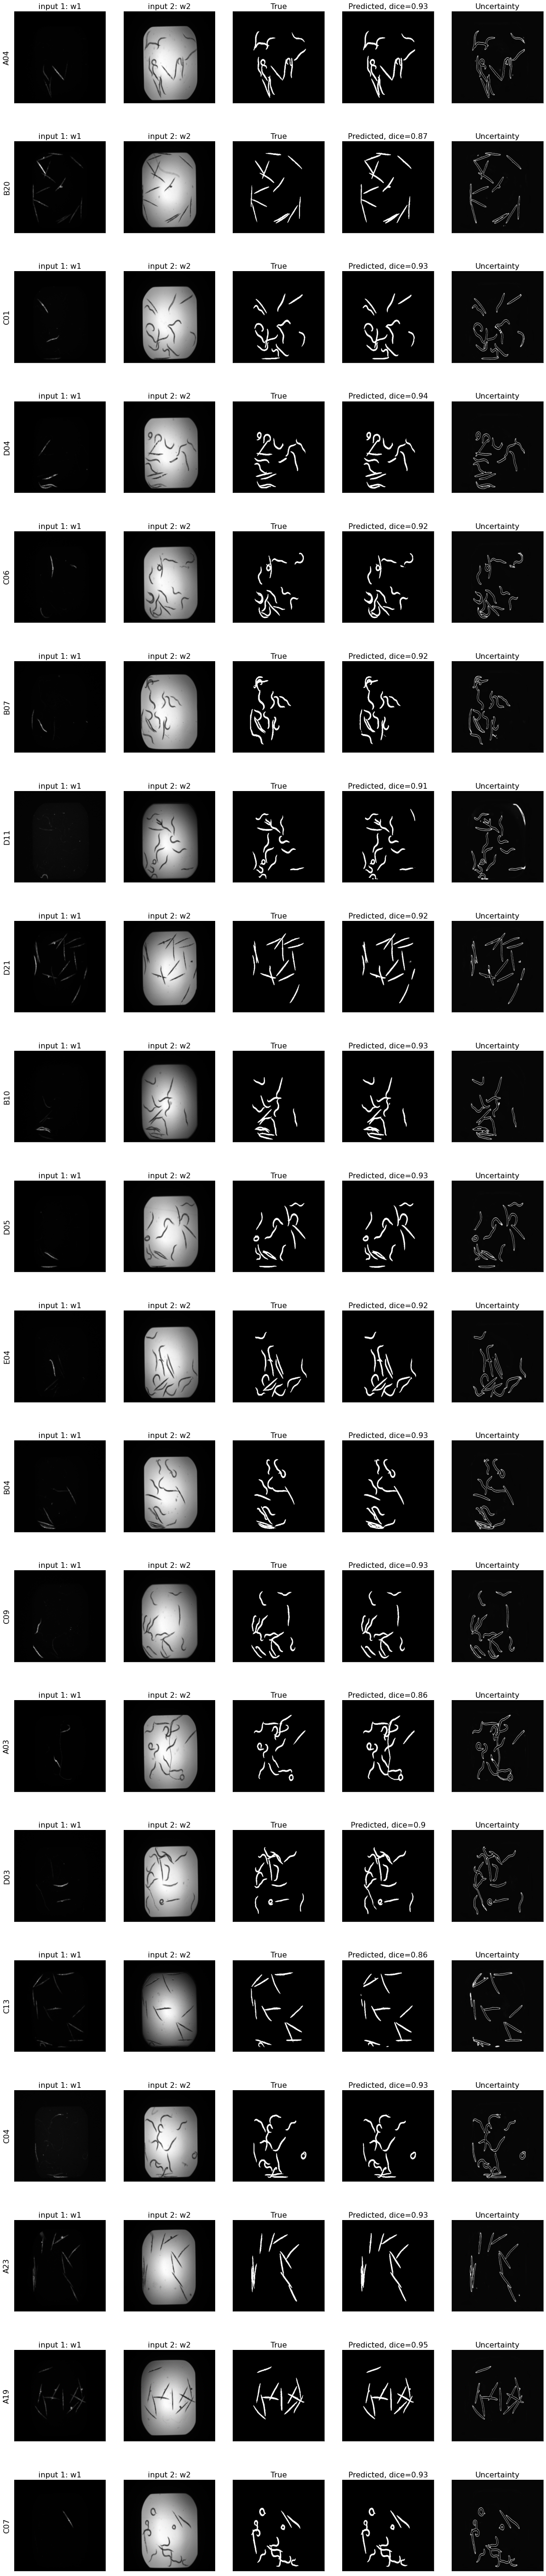

In [34]:
#%% convert predicted mask to binary
threshold=0.5
Y_ts_hat[Y_ts_hat<threshold]=0
Y_ts_hat[Y_ts_hat>=threshold]=1
plt.imshow(Y_ts_hat[0,:,:,0]);plt.colorbar()

#%% calculate dice
dice = []
for i in range(Ntest):
    print(i)
    dice.append(dice2D(Y_ts[i,:,:,0],Y_ts_hat[i,:,:,0]))
dice = np.array(dice)

#%%
fig, axes = plt.subplots(Ntest,5,figsize=(4*5,Ntest*5))
for i in range(Ntest):
    axes[i,0].imshow(X_ts[i,:,:,0], cmap='gray')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('input 1: w1',{'fontsize':16})
    axes[i,0].set_ylabel(well_ts[i],{'fontsize':16})
    
    axes[i,1].imshow(X_ts[i,:,:,1], cmap='gray')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('input 2: w2',{'fontsize':16})
    
    axes[i,2].imshow(Y_ts[i,:,:,0], cmap='gray')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('True',{'fontsize':16})
#    
    axes[i,3].imshow(Y_ts_hat[i,:,:,0], cmap='gray')
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_title('Predicted, dice='+str(np.round(dice[i],2)),{'fontsize':16})
    
    axes[i,4].imshow(U_ts[i,:,:,0], cmap='gray')
    axes[i,4].set_xticks([])
    axes[i,4].set_yticks([])
    axes[i,4].set_title('Uncertainty',{'fontsize':16})

In [36]:
print('mean dice:', dice.mean())
print('median dice:', np.median(dice))

mean dice: 0.9172019641885217
median dice: 0.926119736365049
